# Data Loading and Processing Tutorial

In [1]:
from __future__ import print_function, division
import os
import warnings
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()     # interactive mode
warnings.filterwarnings('ignore')  # Ignore warnings

In [2]:
landmarks_df = pd.read_csv('./data/faces/face_landmarks.csv')
landmarks_df.head(2)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312


In [3]:
n = 65
img_name = landmarks_df.iloc[n, 0]
landmarks = landmarks_df.iloc[n, 1:]  # Series
landmarks = landmarks.as_matrix().astype('float').reshape(-1, 2)  # 第65个照片，把所有part规整为(part_i_x, part_i_y)形式  i=0,...,67
landmarks[:3]

array([[32., 65.],
       [33., 76.],
       [34., 86.]])

Let's write a simple helper function to show an image and its landmarks

In [4]:
def show_landmarks(image, landmarks):  # image: io.imread(xx.jpg文件),numpy array  landmarks对应的landmarks
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

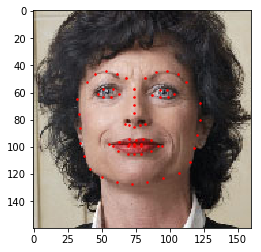

In [7]:
plt.figure()
show_landmarks(io.imread(os.path.join('./data/faces/', img_name)), landmarks)
plt.show()

## 1. Dataset Class

**torch.utils.data.Dataset** is an abstract class representing a dataset. Your custom dataset should inherit **Dataset** and override the following methods: **\_\_len\_\_** and **\_\_getitem\_\_**.

Let’s create a dataset class for our face landmarks dataset. We will read the csv in **\_\_init\_\_** but leave the reading of images to **\_\_getitem\_\_**. This is memory efficient because all the images are not stored in the memory at once but read as required.

In [8]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_df)
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_df.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_df.iloc[idx, 1:].as_matrix().astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
# 思考：封装成class的好处是什么？  

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv', root_dir='./data/faces/')

0 (324, 215, 3) (68, 2)


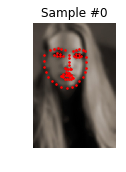

1 (500, 333, 3) (68, 2)


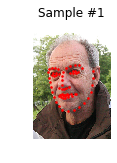

2 (250, 258, 3) (68, 2)


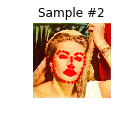

3 (434, 290, 3) (68, 2)


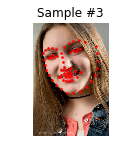

In [10]:
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_landmarks(**sample)
    if i == 3:
        plt.show()
        break

## 2. Transforms

One issue we can see is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we need to write some preprocessing code. Let's create 3 tranforms:

- Rescale: to scale the image

- RandomCrop: to crop from image randomly

- ToTensor: to convert the numpy images to torch images (we need to swap axes)

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. We just need to implement ***\_\_call\_\_*** method and if required, ***\_\_init\_\_*** method.

> 良好的编程习惯，编写成class而非function，这样**设置类参数**只需传参一次即可，**对象类参数**每次使用时传入 --PyTorch和Keras中大量这种Transform类的class

In [11]:
class Rescale(object):
    ''' Rescale the image in a sample to a given size '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):   # 实现tsfm = Transform(param); sample2 = tsfm(sample)中tsfm(sample)的关键API
        image, landmarks = sample['image'], sample['landmarks']
        
        # h, w --> new_h, new_w
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size  # Rescala: 保持原有长宽比，只是同时同比例缩小或增大！
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        
        # apply new_h and new_w
        img = transform.resize(image, (new_h, new_w))   # 对于image，直接调用transform.resize即可，对于landmarks，需要手动resize
        landmarks = landmarks * [new_w / w, new_h / h]  # h and w are swapped for landmarks because for images, x and y axes are axis 1 and 0 respectively
        
        return {'image': img, 'landmarks': landmarks}

In [12]:
class RandomCrop(object):
    ''' Crop randomly the image in a sample '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # h, w --> new_h, new_w --> top, left
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        # apply new_h, new_w, top and left
        img = image[top: top + new_h, left: left + new_w]
        landmarks = landmarks - [left, top]
        
        return {'image': img, 'landmarks': landmarks}

In [13]:
class ToTensor(object):
    ''' Convert ndarrays in sampel to Tensors '''
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because: numpy image - H * W * C    torch image - C * H * W
        img = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(img), 'landmarks': torch.from_numpy(landmarks)}

### Compose Transforms

Let’s say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose **Rescale** and **RandomCrop** transforms.

In [14]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

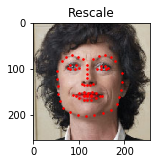

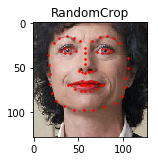

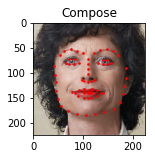

<function matplotlib.pyplot.show(*args, **kw)>

In [15]:
fig = plt.figure()
sample = face_dataset[65]
for i, tsfm in enumerate([scale, crop, composed]):
    transformed_sample = tsfm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfm).__name__)
    show_landmarks(**transformed_sample)
plt.show

## 3. Iterating Through the Dataset

In [16]:
transformed_dataset = FaceLandmarksDataset(csv_file='./data/faces/face_landmarks.csv', root_dir='./data/faces/',
                                          transform=transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

In [17]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple *for* loop to iterate over the data: Batching and Shuffling the data and Load the data in parallel using ***multiprocessing*** workers.

***torch.utils.data.DataLoader*** is an iterator which provides all these features.

> 刘尧：***torch.utils.data.Dataset***用于构建Dataset，支持基本的len和索引以及数据Transformation，然后交由***orch.utils.data.DataLoader***来实现功能：**Batching, Shuffling和Parallel Loading**

In [18]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [21]:
def show_landmarks_batch(sample_batched):
    """Helper Function: Show image with landmarks for a batch of samples"""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size, landmarks_batch[i, :, 1].numpy(), s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


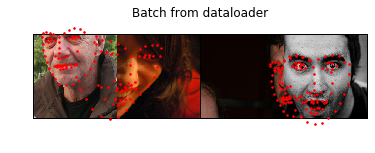

In [22]:
for i_batch, sample_batched in enumerate(dataloader):  # dataloader可以这么迭代！
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 4. Afterword: torchvision

***torchvision*** package provides some common datasets and transforms. You might not even have to write custom classes. One of the more generic datasets available in *torchvision* is ***ImageFolder***. It assumes that images are organized in the following way: *root/class1/xxx.png(jpg/jpeg)*, *root/class2/xxx.jpg(png/jpeg)*...

> 刘尧：***ImageFolder***相当于1中的Dataset Class，用于把原始图片文件构建为dataset，包括Transformation！

In [23]:
import torch
from torchvision import transforms, datasets

In [24]:
data_transform = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train', transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset, batch_size=4, shuffle=True, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: 'hymenoptera_data/train'